# Documentation for the creation and usage of the heatpump library (hplib)




In [1]:
import hplib as hpl
import hplib_database as db
import pandas as pd
import matplotlib.pyplot as plt

## Defintions

**Abbreviations**

| Abbreviation | Meaning |
| --- | --- |
| P_th | Thermal output power in W |
| P_el | Electical input Power in W |
| COP | Coefficient of performance |
| T_in | Input temperature in °C at primary side of the heat pump |
| T_out | Output temperature in °C at secondary side of the heat pump |
| P_th_ref | Thermal output power in W at T_in = -7 °C and T_out = 52 °C |
| P_el_ref | Elecrical output power in W at T_in = -7 °C and T_out = 52 °C |
| COP_ref | Coefficient of performance at T_in = -7 °C and T_out = 52 °C |
| p1,p2,p3 | Fit-Parameters for Fit-Function |


**Group IDs**

| Group ID | Type | Subtype |
| --- | --- | --- |
| 1 | Outdoor Air / Water | Inverter | 
| 2 | Brine / Water | Inverter | 
| 3 | Water / Water | Inverter | 
| 4 | Outdoor Air / Water | On-Off | 
| 5 | Brine / Water | On-Off | 
| 6 | Water / Water | On-Off | 

## Database Preparation
1. we downloaded all manufacturer data from https://keymark.eu/en/products/heatpumps/certified-products
2. then we unzipped the files and used the bash-skript to convert pdf into txt
3. afterwards we used this following functions to create and extent the heatpump keymark database

In [ ]:
# Import keymark data and save to csv database
db.ImportKeymarkData()
# -> this creates /output/database_keymark.csv)

In [ ]:
# Reduce to climate measurement series with average climate, delete redundant entries and save to csv sub-database
db.ReduceKeymarkData('database_keymark.csv','average')
# -> this creates /output/database_keymark_average.csv)

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_in = -7 °C and T_out = 34 °C
db.NormalizeKeymarkData('database_keymark_average.csv')
# -> this creates /output/database_keymark_average_normalized.csv)

In [ ]:
# Identify subtypes like On-Off, Inverter and 2-stages Heatpump and assign group depending on its type and subtype
db.IdentifySubtypes('database_keymark_average_normalized.csv')
# -> this creates /output/database_keymark_average_normalized_subtypes.csv)

In [ ]:
#Calculate parameters p1-p3 for P_th, P_el and COP
db.CalculateFunctionParameters('database_keymark_average_normalized_subtypes.csv')
# -> this creates the final hplib_database.csv

In [5]:
#Calculate generic heatpump models for each group
db.addGeneric()
# -> this overwrites the hplib_database.csv

c:\Users\Hauke\Documents\GitHub\hplib\hplib_database.py:1548: RuntimeWarning: Mean of empty slice.
  p1_P_th_average=pd.unique(Group1['p1_P_th [1/°C]']).mean(0)
D:\Job\Anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Hauke\Documents\GitHub\hplib\hplib_database.py:1549: RuntimeWarning: Mean of empty slice.
  p2_P_th_average=pd.unique(Group1['p2_P_th [1/°C]']).mean(0)
c:\Users\Hauke\Documents\GitHub\hplib\hplib_database.py:1550: RuntimeWarning: Mean of empty slice.
  p3_P_th_average=pd.unique(Group1['p3_P_th [-]']).mean(0)
c:\Users\Hauke\Documents\GitHub\hplib\hplib_database.py:1551: RuntimeWarning: Mean of empty slice.
  p4_P_th_average=pd.unique(Group1['p4_P_th [1/°C]']).mean(0)
c:\Users\Hauke\Documents\GitHub\hplib\hplib_database.py:1552: RuntimeWarning: Mean of empty slice.
  p1_P_el_average=pd.unique(Group1['p1_P_el [1/°C]']).mean(0)
c:\Users\Hauke\Documents\GitHub\hplib\h

In [3]:
#Reduce to unique heat pump models
db.ReduceToUnique()
# -> this overwrites the hplib_database.csv

## Usage for simulation

In [ ]:
# Have a look into the hplib database
database = hpl.loadDatabase()
database

In [3]:
# Define a specific heatpump model and get parameters
parameters = hpl.getParameters('LW 101')
parameters

,Model,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,LW 101,6980.0,3438.0,2.03,4.0,-142.579084,-0.002969,1.393078,142.612651,-9.058103,0.012821,0.32406,9.058905,286.106593,-0.054626,5.406234,-286.015079


In [5]:
# Alternatively, define a "Generic" heatpump model and get parameters
# For every Group ID there is a parameter set which represents an average heatpump of its group
# Please define the Type "Generic", the Group ID (1-9) and P_th_ref in W
parameters = hpl.getParameters('Generic',Group=1, T_in=0, T_out=40, P_th=10000)
parameters

,Model,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p4_P_th [1/°C],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p4_P_el [1/°C],p1_COP [-],p2_COP [-],p3_COP [-],p4_COP [-]
0,Generic,6968.475639,4978.84474,1.399617,1.0,67.415115,-0.003619,0.919535,-67.445192,68.738396,0.009449,0.190328,-68.769238,46.08128,-0.087983,7.053688,-45.927145


In [9]:
# Simulate on time step
# Please define T_in_primary, T_in_secondary in °C and the parameters from the previous step 
# The T_in_secondary is supposed to be heated up by 5 K which then results in T_out
# For a time series create a loop with the function
P_th, P_el, COP, T_out, m_dot = hpl.simulate(0, 60, parameters)
print('P_th: '+str(int(P_th))+' W')
print('P_el: '+str(int(P_el))+' W')
print('COP: '+str(round(COP,3)))

P_th: 5346 W
P_el: 4005 W
COP: 1.335


**Very important:** With the Fit-Parameters p1-p3 for P_th, P_el and COP it is possible to calculate the results with the following methods:

1. P_th and P_el with Fit-Functions and `COP = P_th / P_el`
2. P_th and COP with Fit-Functions and `P_el = P_th / COP`
3. P_el and COP with Fut-Functions and `P_th = P_el * COP`

While the model by Schwarmberger et. al. uses the 1. method, our validation showed, that the 3. method results in better results. Therefore we decided to implement this in the `simulate` definition.

## Examples

**Schematic plotting** of COP, P_el and P_th for an generic air/water heat pump: subtype = **On-Off** 

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

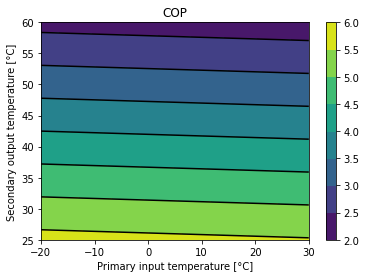

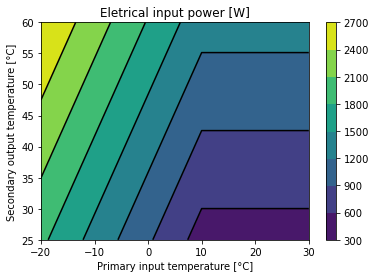

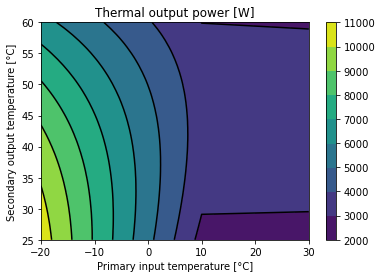

In [17]:
# Define Temperatures
T_in_primary = range(-20, 31) # air temperatur
T_in_secondary = range(20,56) # e.g. temperature from hot water storage

# Load parameters of Generic Air/Water, On-Off
parameters = hpl.getParameters('Generic',Group=2, T_in=-7, T_out=52, P_th = 5000)

# Simulate 
names = ['T_in_primary','P_th', 'P_el', 'COP', 'T_out', 'm_dot']
data = []

for t1 in T_in_primary:
    for t2 in T_in_secondary:
        P_th, P_el, COP, T_out, m_dot = hpl.simulate(0, t2, parameters,t1)
        data.append([t1, P_th, P_el, COP, T_out, m_dot])

results = pd.DataFrame(data, columns=names)

# Plot COP
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in_primary'], results['T_out'], results['COP'])
ax1.tricontour(results['T_in_primary'], results['T_out'], results['COP'], colors='k')
fig1.colorbar(plot)
ax1.set_title('COP')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot electrical input power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in_primary'], results['T_out'], results['P_el'])
ax1.tricontour(results['T_in_primary'], results['T_out'], results['P_el'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Eletrical input power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

# Plot thermal output power
fig1, ax1 = plt.subplots()
plot = plt.tricontourf(results['T_in_primary'], results['T_out'], results['P_th'])
ax1.tricontour(results['T_in_primary'], results['T_out'], results['P_th'], colors='k')
fig1.colorbar(plot)
ax1.set_title('Thermal output power [W]')
ax1.set_xlabel('Primary input temperature [°C]')
ax1.set_ylabel('Secondary output temperature [°C]')
fig1.show

In [ ]:
T_in_primary = [-7,2,7,12] # air temperatur
T_in_secondary = range(20,56) # e.g. temperature from hot water storage

# Load parameters of Generic Air/Water, On-Off
parameters = hpl.getParameters('WPE-I 87 H 400 Premium')#'Generic',Group=2, T_in=-7, T_out=52, P_th = 5000)

# Simulate 
names = ['T_in_primary','P_th', 'P_el', 'COP', 'T_out', 'm_dot']
data = []

for t1 in T_in_primary:
    for t2 in T_in_secondary:
        P_th, P_el, COP, T_out, m_dot = hpl.simulate(0, t2,t1, parameters)
        data.append([t1, P_th, P_el, COP, T_out, m_dot])

results = pd.DataFrame(data, columns=names)

In [ ]:
results